# Notebook découverte du jeu de données et premier modèle de machine learning

Dans ce notebook, je vais afficher et travailler les données fournies par le client afin de les rendre compatibles pour une exploitation par machine learning.  
Puis, je testerai un ou deux modèles de machine learning afin d'en tirer des premières conclusions.  
  
Le résultat que le client attend est une intelligence artificielle qui peut prédire avec fiabilité si un passager survit ou pas dans l'incident du Titanic

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve, learning_curve, train_test_split
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

## Nettoyage et interprétation graphique des données 

In [2]:
titanic_df_temp= pd.read_csv('data/train.csv')
titanic_df_temp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- "PassengerId" : identifiant associé à chacun des 891 passagers de notre jeu de données
- "Survived" : sort du passager lors du naufrage du Titanic : 0 = décédé,  1 = survivant
- "Pclass" : classe économique dans laquelle le passager voyageait : 1 = première classe, 2 = deuxième classe, 3 = troisième classe
- "Name" : nom complet du passager
- "Sex" : sexe du passager : female, male
- "Age" : âge du passager en années
- "SibSp" : nombre de frères/sœurs/conjoints du passager également à bord du Titanic
- "Parch" : nombre de parents/enfants du passager également à bord du Titanic
- "Ticket" : numéro du billet du passager
- "Fare" : tarif du billet du passager
- "Cabin" : identifiant de la cabine du passager 
- "Embarked" : port d'embarquement du passager : C = Cherbourg, Q = Queenstown, S = Southampton

A la vue du dataFrame, on peut se permettre de mettre la colonne "Passengerid" en index de notre dataframe

In [3]:
titanic_df=titanic_df_temp.set_index('PassengerId').copy()
titanic_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# ensemble des fonctions utilisées pour nettoyer changer le dataframe

def miss_values(col):
    return col.isnull().sum()

def embarked_transfo(ligne) :
    if ligne['Embarked']=='C' :
        return 1
    elif ligne['Embarked']=='S' :
        return 2
    elif ligne['Embarked']=='Q' :
        return 3
    else :
        return None

def sex_transfo(ligne) :
    if ligne['Sex']=='male' :
        return 1
    elif ligne['Sex']=='female' :
        return 2
    else :
        return None

def age_transfo(ligne) :
    if ligne['Age'] >= 18 :
        return 1
    elif ligne['Age'] < 18 :
        return 0
    else :
        return None

In [5]:
# On va calculer le nombre de cellule vide par colonne pour notre dataframe
titanic_df.apply(miss_values, axis=0)

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

La cellule précédente me permet d'identifier les cellules vides dans les lignes du dataframe.  
Ainsi, la colonne "Cabin" possède trop de vide, elle risque de poser problème pour l'algorithme de machine learning. je décide de la supprimer.  
Pour la colonne "Age" je peux soit la supprimer, soit retirer les lignes vides ou les remplir avec une valeur arbitraire. Je décide de retirer l'ensemble des  lignes vides, car l'âge risque d'être un facteur important pour notre prédiction de survivants.  
  
La colonne "Name" peut avoir un intérêt, mais nécessiterait une réflexion plus pousser en corrélation avec les colonnes  "Ticket", "SibSp" et "Parch".  
Afin de conclure sur l'utilité de certaines colonnes, je vais créer un pairplot pour avoir un premier visuel sur le comportement des données.

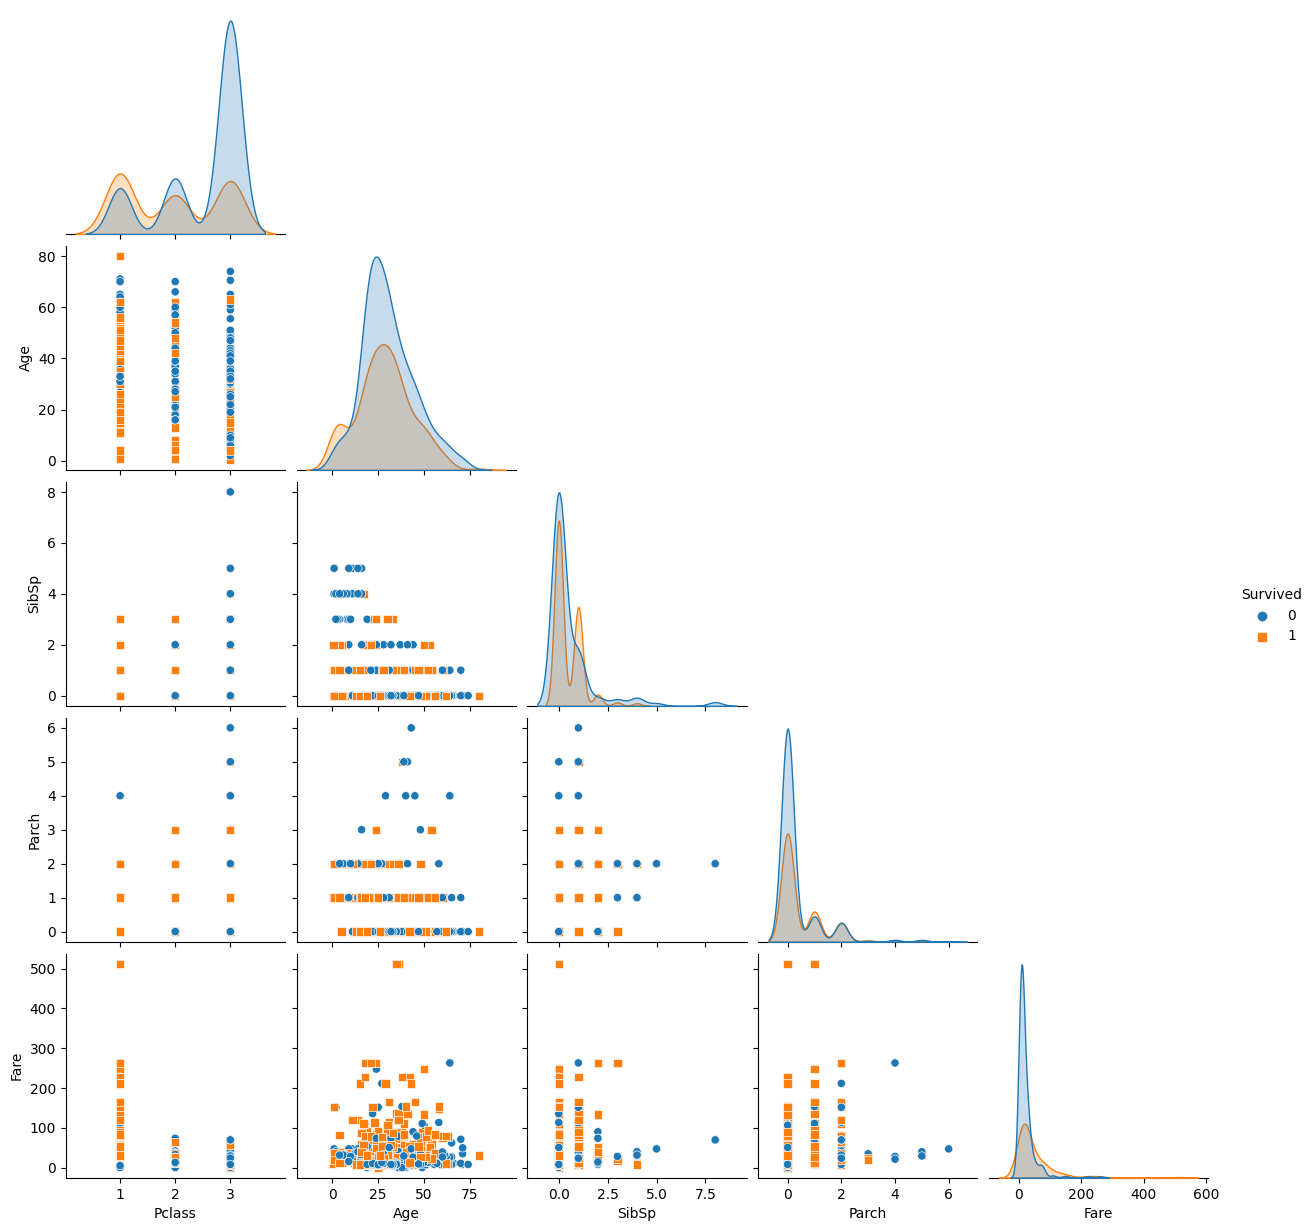

In [6]:
sns.pairplot(titanic_df.drop(["Name", "Ticket"], axis='columns'), hue='Survived', markers=['o', 's'], corner=True)
plt.show()

In [7]:
titanic_df_graph=titanic_df.drop(['Name'], axis='columns').copy()

#Transformation du port d'embarquement en valeur numérique C=>1, S=>2, Q=>3
titanic_df_graph['Num_Embarked']=titanic_df_graph.apply(embarked_transfo, axis=1)

#Transformation du sexe en valeur numérique male=>1, female=>2
titanic_df_graph['Num_sex']=titanic_df_graph.apply(sex_transfo, axis=1)

#Transformation de l'age en label mineur/majeur : 18 et + =>1, moins de 18 =>0
titanic_df_graph['Label_mineur_majeur']= titanic_df_graph.apply(age_transfo, axis=1)

#Drop des colonnes "Cabin" et "Ticket" car peu ou non exploitable
titanic_df_graph.drop(['Cabin'], axis='columns', inplace=True)
titanic_df_graph.drop(['Ticket'], axis='columns', inplace=True)

#On se sépare des lignes ayant des valeurs vides
titanic_df_graph.dropna(inplace=True)

#Puis on drop les colonnes que l'on a transformé
titanic_df_graph.drop(['Embarked', 'Sex'], axis='columns', inplace=True)

titanic_df_graph.reset_index(drop=True, inplace=True)
titanic_df_graph

,Survived,Pclass,Age,SibSp,Parch,Fare,Num_Embarked,Num_sex,Label_mineur_majeur
0,0,3,22.0,1,0,7.2500,2.0,1,1.0
1,1,1,38.0,1,0,71.2833,1.0,2,1.0
2,1,3,26.0,0,0,7.9250,2.0,2,1.0
3,1,1,35.0,1,0,53.1000,2.0,2,1.0
4,0,3,35.0,0,0,8.0500,2.0,1,1.0
...,...,...,...,...,...,...,...,...,...
707,0,3,39.0,0,5,29.1250,3.0,2,1.0
708,0,2,27.0,0,0,13.0000,2.0,1,1.0
709,1,1,19.0,0,0,30.0000,2.0,2,1.0
710,1,1,26.0,0,0,30.0000,1.0,1,1.0


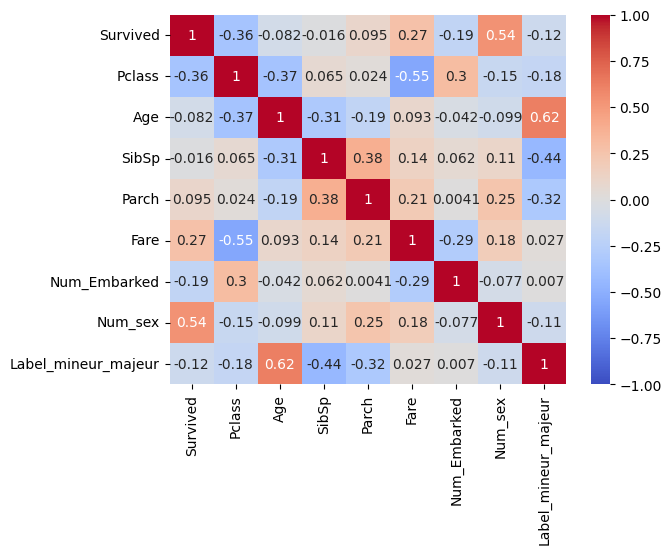

In [24]:
# On affiche sous forme de matrice les niveaux de corrélation entre les variables numériques du dataframe.
sns.heatmap(titanic_df_graph.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')
plt.show()


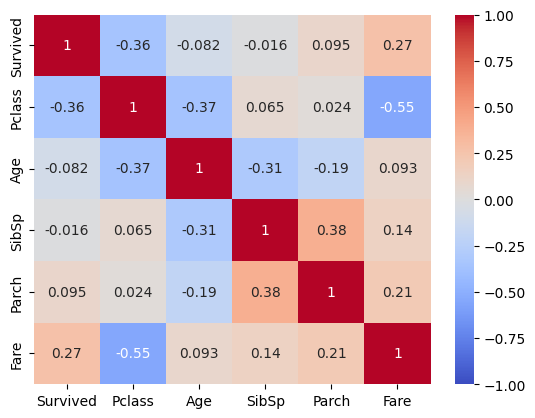

In [28]:
# Heatmap de la matrice de corrélation en retirant les colonnes encodées telles que Num_Embarked
sns.heatmap(
            titanic_df_graph.loc[:, ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].corr(), 
            vmin = -1, 
            vmax = +1, 
            annot = True, 
            cmap = 'coolwarm', 
            )
plt.show()

La heatmap me permet de conclure que la survie d'un individu est surtout influencé par le sexe de l'individu, le prix et la classe du billet.

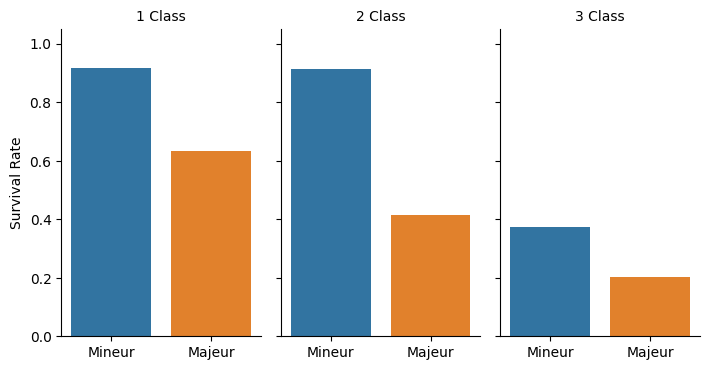

In [9]:
# Comparaison entre la survie d'un majeur et d'un mineur séparer part le niveau de classe
grap=sns.catplot(
            x="Label_mineur_majeur", 
            y="Survived", 
            data=titanic_df_graph,
            errwidth=0,
            kind='bar',
            col='Pclass',
            height=4, 
            aspect=.6
        )
grap.set_xticklabels(["Mineur", "Majeur"])
grap.set_axis_labels("", "Survival Rate")
grap.set_titles("{col_name} Class")

plt.show()


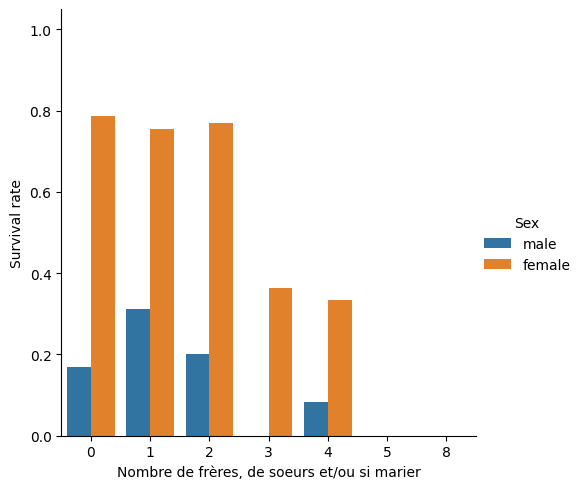

In [31]:
#Comparasion du taux de survie entre le nombre de frère-soeur/marier par rapport au sexe de l'individu
sns.catplot(x='SibSp', y='Survived', data=titanic_df, kind='bar', hue='Sex', errwidth=0)
plt.xlabel("Nombre de frères, de soeurs et/ou si marier")
plt.ylabel("Survival rate")
plt.show()

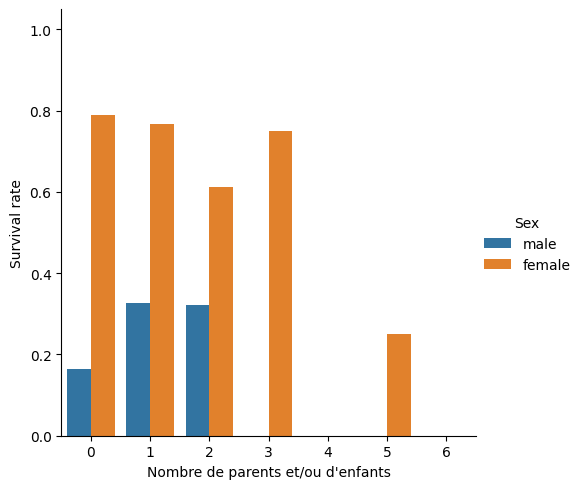

In [32]:
#Comparasion du taux de survie entre le nombre de parents/enfants par rapport au sexe de l'individu
sns.catplot(x='Parch', y='Survived', data=titanic_df, kind='bar', hue='Sex', errwidth=0)
plt.xlabel("Nombre de parents et/ou d'enfants")
plt.ylabel("Survival rate")
plt.show()

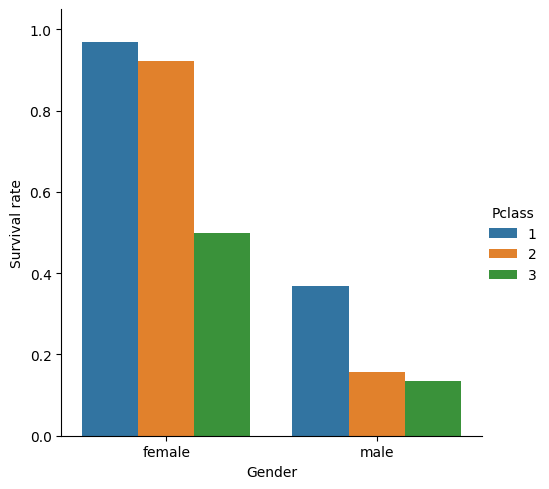

In [ ]:
#Comparasion du taux de survie entre les sexes par rapport a la classe du billet
sns.catplot(x='Sex', y='Survived', data=titanic_df, kind='bar', hue='Pclass', errwidth=0, order = ["female", "male"])
plt.xlabel("Gender")
plt.ylabel("Survival rate")
plt.show()

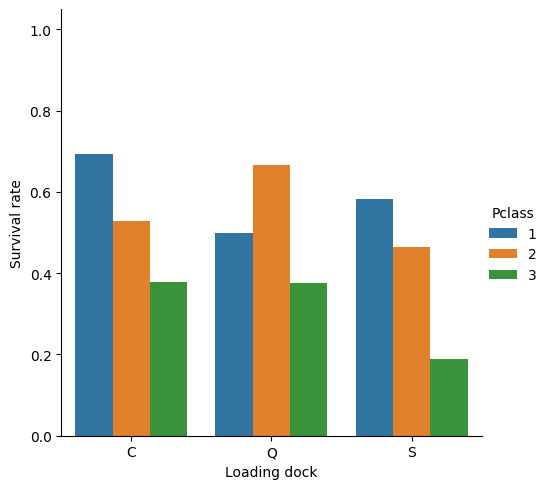

In [11]:
# Comparaison du taux de survie par rapport au port d'embarquement séparer par le niveau de classe du billet
sns.catplot(x='Embarked', y='Survived', data=titanic_df,kind='bar', hue='Pclass', errwidth=0, order = ["C", "Q", "S"])
plt.xlabel("Loading dock")
plt.ylabel("Survival rate")
plt.show()

Ainsi, avec les différents graphiques et la heatmap on peut considérer que l'âge, le sexe, le prix du billet et la classe du passager ont une influence sur la survie d'un individu dans le titanic.  
  
Il est possible d'exploiter le nombre de frères/soeurs/conjoints et le nombre de parents/enfants.  

Dans la prochaine partie on va mettre en place des méthodes de machine learning pour essayer de prédire la survie d'un individu dans le titanic.

## Mise en place des méthodes de machine learning

In [12]:

#titanic_df_clean=titanic_df_graph.drop(['SibSp', 'Parch'], axis='columns').copy()
titanic_df_clean=titanic_df_graph.copy()

In [13]:

# On sépare les features du target :
features, target = titanic_df_clean.loc[:, 'Pclass':'Num_Embarked'], titanic_df_clean["Survived"]

# On split notre dataframe en deux. La taille choisie est de 0,4 afin de d'assurer une taille suffisante 
# pour le jeu de données de test :
feat_train, feat_test, target_train, target_test = train_test_split(features, target, test_size = 0.4)

# On standardise :  
scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)
feat_test = scaler.transform(feat_test)

Je vais, pour commencer, tester le modèle Support Vector Machine(SVM) pour la classification avec un kernel linéaire 

0.6982456140350877
              precision    recall  f1-score   support

           0       0.71      0.82      0.76       168
           1       0.67      0.52      0.59       117

    accuracy                           0.70       285
   macro avg       0.69      0.67      0.67       285
weighted avg       0.69      0.70      0.69       285



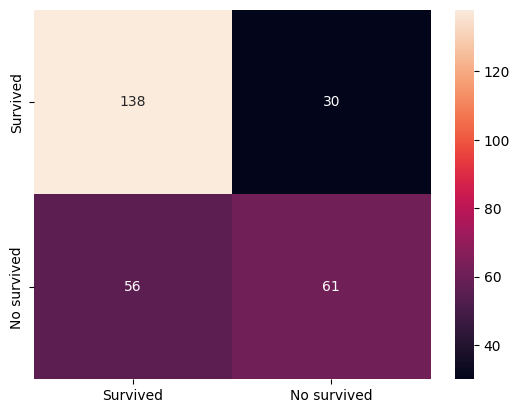

In [14]:
# SVC linear

# On initalise le modèle : 
classifier = SVC(kernel = 'linear')

# On l'entraîne sur nos données d'entraînement :
classifier.fit(feat_train, target_train)

# On l'utilise pour prédire sur les données de test :
predict_class = classifier.predict(feat_test)

# On calcule l'accuracy du modèle :  
acc = accuracy_score(predict_class, target_test)
print(acc)

# On ajoute des noms aux index et aux colonnes à la matrice de confusion
classes_names = ['Survived','No survived']
cm = pd.DataFrame(confusion_matrix(target_test, predict_class), 
                  columns=classes_names, index = classes_names)

# On affiche une heatmap de seaborn pour visualiser la matrice de confusion
sns.heatmap(cm, annot=True, fmt='d')

print(classification_report(target_test, predict_class))

Les metriques récupérées à l'aide de la matrice de confusion sont basses.  
Ainsi, je vais tester cette fois un modèle de Nearest neighboors(Knn) pour la classification et comparer les métriques obtenues pour le même jeu d'entraînement.

0.6771929824561403
              precision    recall  f1-score   support

           0       0.71      0.76      0.73       168
           1       0.62      0.56      0.59       117

    accuracy                           0.68       285
   macro avg       0.67      0.66      0.66       285
weighted avg       0.67      0.68      0.67       285



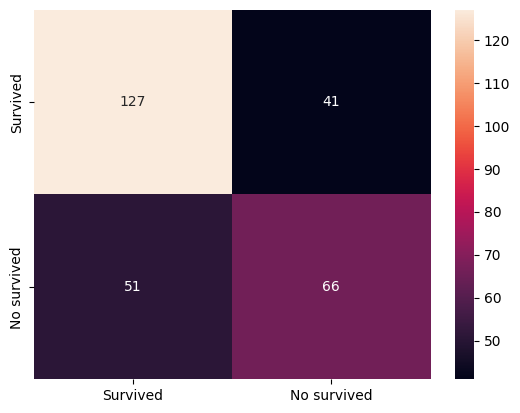

In [15]:
# Nearest Neighboors Classifier model

# On initalise le modèle : 
neighbors_classif = KNeighborsClassifier()

# On l'entraîne sur nos données d'entraînement :
neighbors_classif.fit(feat_train, target_train)

# On l'utilise pour prédire sur les données de test :
predict_class = neighbors_classif.predict(feat_test)

# On calcule l'accuracy du modèle :  
acc = accuracy_score(predict_class, target_test)
print(acc)

# On ajoute des noms aux index et aux colonnes à la matrice de confusion
classes_names = ['Survived','No survived']
cm = pd.DataFrame(confusion_matrix(target_test, predict_class), 
                  columns=classes_names, index = classes_names)

# On affiche une heatmap de seaborn pour visualiser la matrice de confusion
sns.heatmap(cm, annot=True, fmt='d')

print(classification_report(target_test, predict_class))

Je remarque que les métriques pour nos modèles testés sont très proches et ont des valeurs plutôt basses.  
Cela signifie soit que les données transmises manquent de travail sur leur préparation ou que les modèles manquent d'optimisation. Par exemple, le nombre de voisins proches utilisé par le classifieur Knn n'est pas le nombre adapté.  
  
Dans les parties qui suivent je vais tenter d'optimiser le modèle Knn avec une courbe de validation pour déterminer le meilleur nombre de voisins proches.

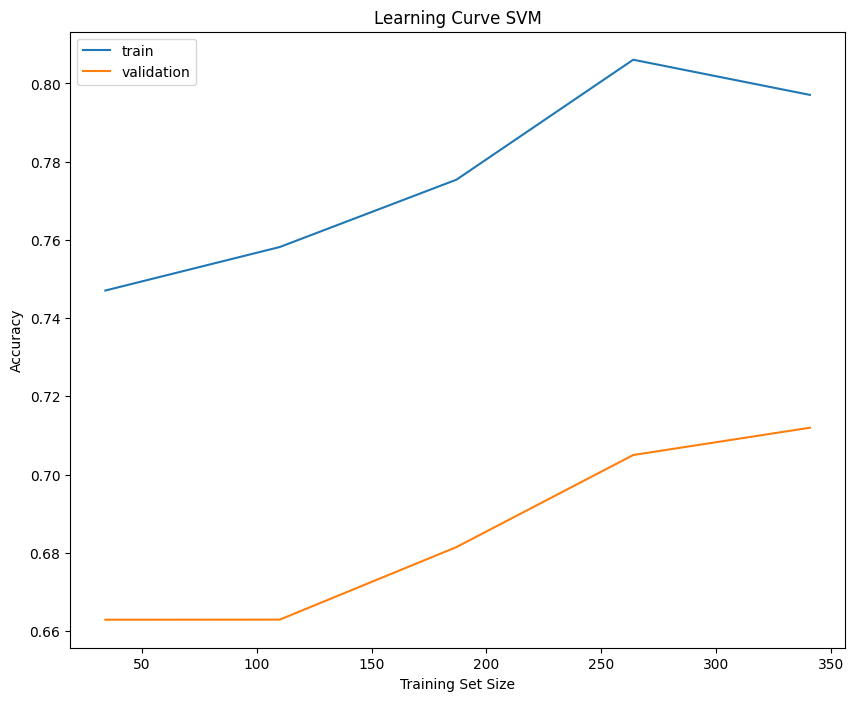

In [16]:
# Learning Curve
# La courbe d'apprentissage comme pour la courbe de validation s'appuie sur une comparaison d'une courbe d'évolution
# de l'accuracy en fonction de la taille de l'échantillon d'entrainement à une courbe de cross-validation en fonction 
# de la taille de l'échantillon. 


train_sizes, train_scores, test_scores = learning_curve(
    estimator=KNeighborsClassifier(),
    X=feat_train,
    y=target_train,
    cv=5,
    scoring="accuracy"
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Learning Curve SVM")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")

plt.show()

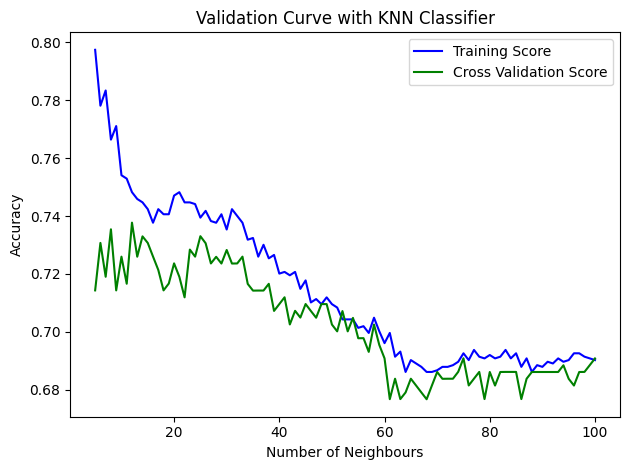

In [17]:
# Validation Curve
# La courbe de validation permet de calculer l'accuracy à la fois pour l'entraînement de mon modèle et
# l'accuracy suivant un modèle de cross-validation pour avoir un résultat plus réel

# La croos-validation est une technique qui sépare l'échantillon d'entrainement donné en plusieurs sous-échantillons 
# de taille fixe. Chaque sous-échantillon devient, pour la cross-validation, soit un échantillon d'entrainement soit un 
# échantillon de test et on calcule l'accuracy pour toutes ces variations entre les échantillons d'entrainement et de tests.

# Pour cette courbe de validation, on fera varier le nombre de voisin. Ainsi, on pourra extraire grâce à la courbe de 
# cross-validation la valeur optimale du nombre de voisins pour notre Knn classifieur.

# La courbe de validation permet ainsi de déterminer les optimaux des hyperparamètres des différents modèles comme le nombre
# de voisins pour un Knn classifier ou le gamma pour un SVC-rbf


parameter_range = np.linspace(5, 100, 95, dtype=int)

# Calculate accuracy on training and test set using the
# gamma parameter with 5-fold cross validation
train_score, test_score = validation_curve(KNeighborsClassifier(), 
                                       feat_train, 
                                       target_train,
                                       param_name = "n_neighbors",
                                       param_range = parameter_range,
                                        cv = 5, scoring = "accuracy")
 
# Calculating mean of training score
mean_train_score = np.mean(train_score, axis = 1)
 
# Calculating mean of testing score
mean_test_score = np.mean(test_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score,
   label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with KNN Classifier")
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

#On récupère le nombre de voisin optimale pour ce split de données
kopti=parameter_range.take(mean_test_score.argmax())

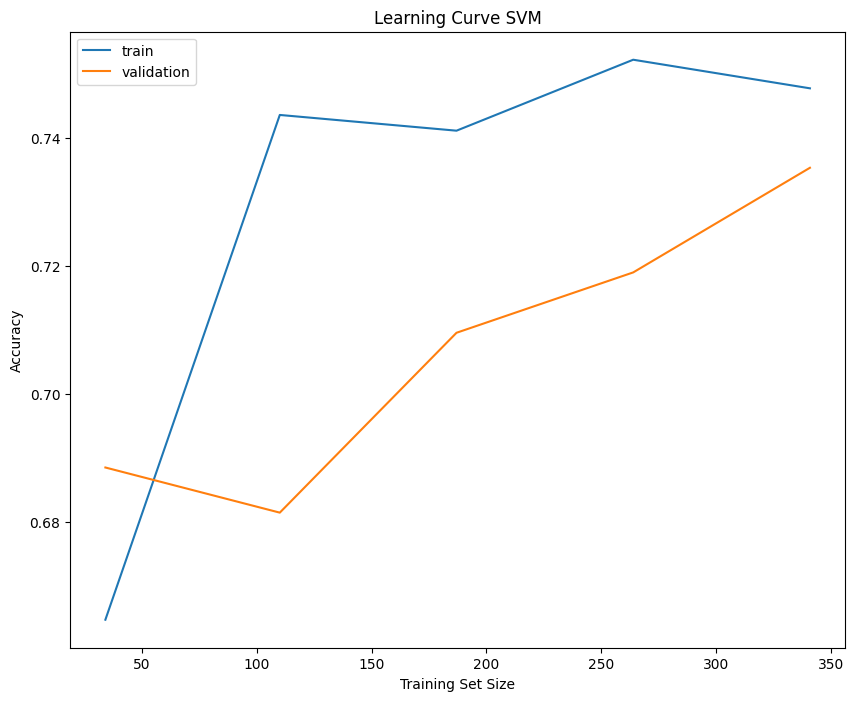

In [18]:
# Learning Curve
# On refait une courbe d'apprentissage pour voir l'influence d'optimiser un hyperparamètres sur cette courbe

train_sizes, train_scores, test_scores = learning_curve(
    estimator=KNeighborsClassifier(n_neighbors=kopti),
    X=feat_train,
    y=target_train,
    cv=5,
    scoring="accuracy"
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")

plt.title("Learning Curve Knn avec n_neighboors opti")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")

plt.show()

La cross-validation learning curve montre que l'accuracy, pour les données du titanic dans le but de déterminer si quelqu'un survit ou pas, a tendance à être meilleure quand la taille du jeu de données est importante.   
Les données pour le titanic sont, par définition, limitées par le nombre de passagers présent dans l'incident, si on souhaite améliorer le modèle de machine learning on peut encore chercher les optimaux de nos hyperparamètres, changer de modèle ou travailler pour transformer le Dataframe pour le rendre plus compatible avec les modèles de machine learning

0.7087719298245614
              precision    recall  f1-score   support

           0       0.71      0.85      0.77       168
           1       0.70      0.51      0.59       117

    accuracy                           0.71       285
   macro avg       0.71      0.68      0.68       285
weighted avg       0.71      0.71      0.70       285



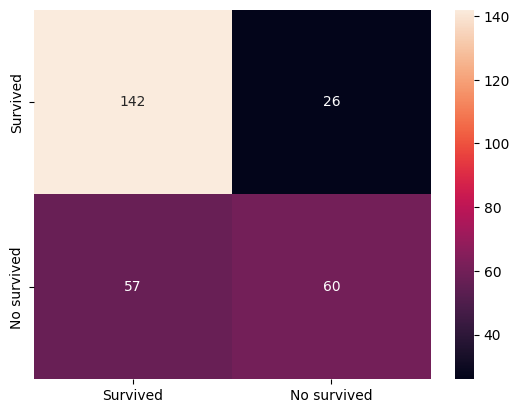

In [19]:
# On initalise le modèle : 
neighbors_classif = KNeighborsClassifier(n_neighbors=kopti)

# On l'entraîne sur nos données d'entraînement :
neighbors_classif.fit(feat_train, target_train)

# On l'utilise pour prédire sur les données de test :
predict_class = neighbors_classif.predict(feat_test)

# On calcule l'accuracy du modèle :  
acc = accuracy_score(predict_class, target_test)
print(acc)

# On ajoute des noms aux index et aux colonnes à la matrice de confusion
classes_names = ['Survived','No survived']
cm = pd.DataFrame(confusion_matrix(target_test, predict_class), 
                  columns=classes_names, index = classes_names)

# On affiche une heatmap de seaborn pour visualiser la matrice de confusion
sns.heatmap(cm, annot=True, fmt='d')

print(classification_report(target_test, predict_class))

On remarque une légère amélioration de l'accuracy calculer pour la prédiction sur le jeu de données de test.  
Cependant, ça peut-être dû aussi au fait qu'il s'agit d'un deuxième entrainement du classifieur bien que j'aie changé le nombre de voisins.  
  
Pour améliorer mes modèles il est possible d'aller plus loin dans le second notebook. Je peux travailler sur l'encode des valeurs non numériques de mon dataframe, optimiser plus d'hyperparamètres et aussi automatiser ces deux exemples.